## Image

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the model
model = Sequential()
model.add(MobileNetV2(include_top=False, weights='imagenet', input_shape=(32, 32, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1563/1563 [==============================] - 129s 83ms/step - loss: 1.6693 - accuracy: 0.4431 - val_loss: 3.3633 - val_accuracy: 0.2272
Epoch 2/5
1563/1563 [==============================] - 129s 83ms/step - loss: 1.7206 - accuracy: 0.4140 - val_loss: 4.1456 - val_accuracy: 0.2879
Epoch 3/5
1563/1563 [==============================] - 132s 84ms/step - loss: 1.7916 - accuracy: 0.3775 - val_loss: 3.8961 - val_accuracy: 0.1701
Epoch 4/5
1563/1563 [==============================] - 130s 83ms/step - loss: 1.6242 - accuracy: 0.4356 - val_loss: 2.0379 - val_accuracy: 0.3877
Epoch 5/5
1563/1563 [==============================] - 126s 81ms/step - loss: 1.8361 - accuracy: 0.3556 - val_loss: 2.7881 - val_accuracy: 0.2607


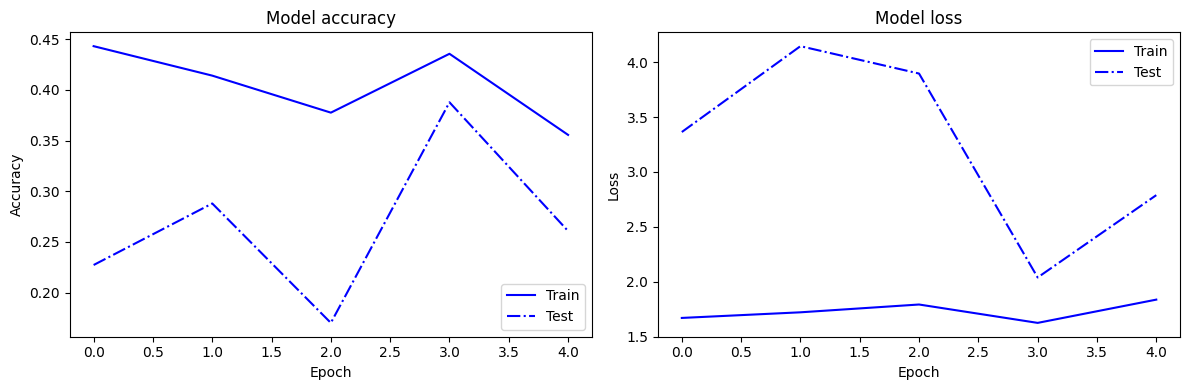

In [6]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue')
plt.plot(history.history['val_accuracy'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='blue')
plt.plot(history.history['val_loss'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Video

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import os

In [17]:
# Load video data
data_dir = 'UCF-101'
videos = []
labels = []
for category in os.listdir(data_dir)[:10]:  # Use only the first 10 categories for simplicity
    for video_file in os.listdir(os.path.join(data_dir, category))[:10]:  # Use only the first 10 videos of each category
        video = []
        cap = cv2.VideoCapture(os.path.join(data_dir, category, video_file))
        for _ in range(30):  # Use only the first 30 frames of each video
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (64, 64))
            video.append(frame)
        cap.release()
        videos.append(video)
        labels.append(category)

# Convert videos and labels to numpy arrays
videos = np.array(videos)
labels = np.array(labels)

# Normalize videos
videos = videos.astype('float32') / 255

# Convert category names to numerical labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# Convert labels to one-hot vectors
labels = to_categorical(labels, num_classes=10)


# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

In [22]:
# Define the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 64, 64, 3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
3/3 [==============================] - 3s 653ms/step - loss: 137.6896 - accuracy: 0.1250 - val_loss: 292.2478 - val_accuracy: 0.0500
Epoch 2/10
3/3 [==============================] - 2s 610ms/step - loss: 249.8671 - accuracy: 0.1625 - val_loss: 132.9448 - val_accuracy: 0.2000
Epoch 3/10
3/3 [==============================] - 2s 636ms/step - loss: 119.9273 - accuracy: 0.2750 - val_loss: 50.0681 - val_accuracy: 0.2000
Epoch 4/10
3/3 [==============================] - 2s 612ms/step - loss: 53.5402 - accuracy: 0.3375 - val_loss: 22.4365 - val_accuracy: 0.4500
Epoch 5/10
3/3 [==============================] - 2s 648ms/step - loss: 27.3358 - accuracy: 0.5750 - val_loss: 14.6785 - val_accuracy: 0.4500
Epoch 6/10
3/3 [==============================] - 2s 627ms/step - loss: 10.6893 - accuracy: 0.6750 - val_loss: 9.2575 - val_accuracy: 0.4500
Epoch 7/10
3/3 [==============================] - 2s 620ms/step - loss: 1.8838 - accuracy: 0.8500 - val_loss: 6.4768 - val_accuracy: 0.4500
Epoc

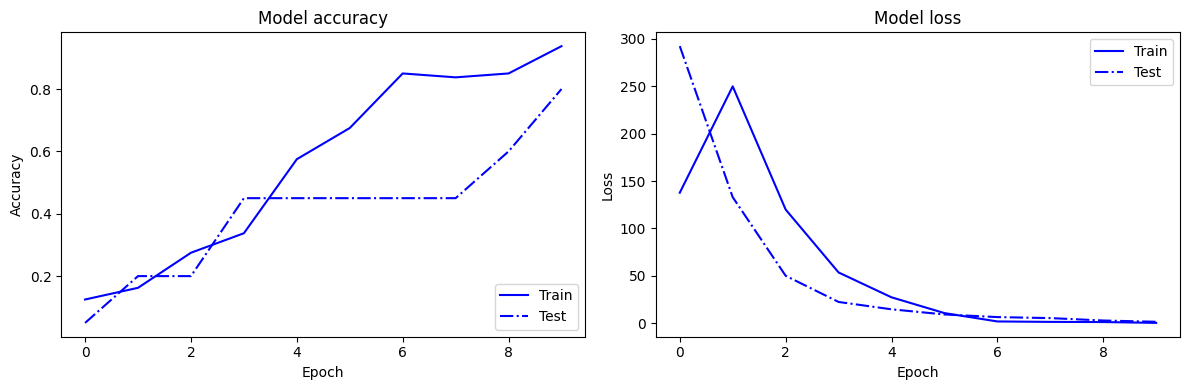

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue')
plt.plot(history.history['val_accuracy'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='blue')
plt.plot(history.history['val_loss'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Audio

In [25]:
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [39]:
# Define function to extract features from audio files
def extract_features(file_path, mfcc=True, mel=True, chroma=True):
    with open(file_path, 'rb') as file:
        audio, sample_rate = librosa.load(file)
        features = []
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(
                y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
            features.extend(mfccs)
        if mel:
            mel_spectrogram = np.mean(librosa.feature.melspectrogram(
                y=audio, sr=sample_rate).T, axis=0)
            features.extend(mel_spectrogram)
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(
                y=audio, sr=sample_rate).T, axis=0)
            features.extend(chroma)
    return features


# Initialize features and labels as empty lists
features = []
labels = []

# Define the directory for fold1
fold1_dir = os.path.join(data_dir, 'fold1')

# Load audio data from fold1
for file in os.listdir(fold1_dir):
    if file.endswith('.wav'):
        class_label = file.split('-')[1]
        file_path = os.path.join(fold1_dir, file)
        print(f"Processing file: {file_path}")
        if os.path.exists(file_path):
            try:
                feature = extract_features(file_path)
                print(f"Features extracted: {len(feature)}")
                if len(feature) == 0:
                    print(f"No features extracted from file: {file_path}")
                features.append(feature)  # Append feature to features
                labels.append(class_label)
            except Exception as e:
                print(f"Error processing file '{file}': {str(e)}")
        else:
            print(f"File not found: {file_path}")
    else:
        print(f"File skipped (not a .wav file): {file}")

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Convert labels to one-hot vectors
labels = to_categorical(labels)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

File skipped (not a .wav file): .DS_Store
Processing file: UrbanSound8K/audio\fold1\101415-3-0-2.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\101415-3-0-3.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\101415-3-0-8.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102106-3-0-0.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102305-6-0-0.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102842-3-0-1.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102842-3-1-0.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102842-3-1-5.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\102842-3-1-6.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\103074-7-0-0.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\103074-7-0-1.wav
Features extracted: 180
Processing file: UrbanSound8K/audio\fold1\103

In [40]:
# Define the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
22/22 [==============================] - 1s 12ms/step - loss: 3.8205 - accuracy: 0.3954 - val_loss: 1.2439 - val_accuracy: 0.6343
Epoch 2/20
22/22 [==============================] - 0s 7ms/step - loss: 1.3764 - accuracy: 0.6418 - val_loss: 0.8417 - val_accuracy: 0.7429
Epoch 3/20
22/22 [==============================] - 0s 7ms/step - loss: 0.9440 - accuracy: 0.7249 - val_loss: 0.6896 - val_accuracy: 0.7600
Epoch 4/20
22/22 [==============================] - 0s 7ms/step - loss: 0.8459 - accuracy: 0.7779 - val_loss: 0.6091 - val_accuracy: 0.8114
Epoch 5/20
22/22 [==============================] - 0s 7ms/step - loss: 0.5957 - accuracy: 0.8095 - val_loss: 0.5311 - val_accuracy: 0.8286
Epoch 6/20
22/22 [==============================] - 0s 7ms/step - loss: 0.5031 - accuracy: 0.8438 - val_loss: 0.5458 - val_accuracy: 0.8400
Epoch 7/20
22/22 [==============================] - 0s 7ms/step - loss: 0.4619 - accuracy: 0.8524 - val_loss: 0.4586 - val_accuracy: 0.8343
Epoch 8/20
22/22 [=

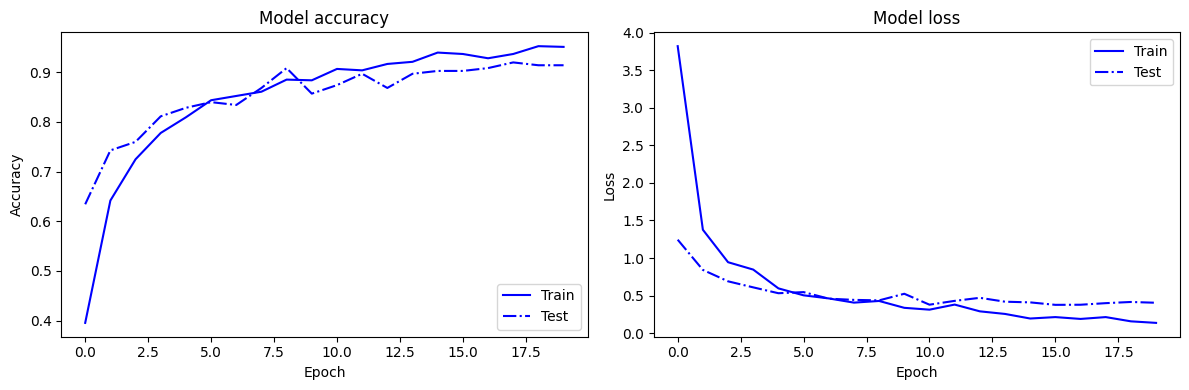

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue')
plt.plot(history.history['val_accuracy'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='blue')
plt.plot(history.history['val_loss'], label='Test', color='blue', linestyle = "dashdot")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()